In [139]:
import numpy as np
import pcs as pcs
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import least_squares
from nepc import nepc
from nepc.methods.mp import mp as mp
from nepc.methods.thomson import thomson as thomson
from nepc.util.constants import N2_DIATOMIC_CONSTANTS
from nepc.util.constants import MU_NITROGEN_KG
from nepc.util.constants import WAVENUMBER_PER_EV as WAVENUMBER_PER_EV
from numpy import exp

# Plot psi_v, v=10

In [2]:
N2_DIATOMIC_CONSTANTS.keys()

dict_keys(['N2(X1Sigmag+)', 'N2(A3Sigmau+)', 'N2(B3Pig)', 'N2(W3Deltau)', 'N2(Bp3Sigmau-)', 'N2(ap1Sigmau-)', 'N2(a1Pig)', 'N2(w1Deltau)', 'N2(C3Piu)', 'N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)', 'N2+(C2Sigmau+)'])

# Compute Overlap Matrix and Check for Identity

In [3]:
overlap_X = thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False)

In [4]:
thomson.rmse_diagonal_elements(np.asarray(overlap_X))

4.115206214252541e-07

In [5]:
thomson.incremental_rmse_diagonal_elements(np.asarray(overlap_X))

i: 1; rmse: 1.2434497875801753e-14
i: 2; rmse: 5.844456963317449e-14
i: 3; rmse: 8.705960933385516e-14
i: 4; rmse: 1.3228087202133447e-13
i: 5; rmse: 8.628411822787013e-12
i: 6; rmse: 2.0702115185528743e-11
i: 7; rmse: 7.328597843980401e-10
i: 8; rmse: 2.784505527958912e-09
i: 9; rmse: 4.102019172911683e-08
i: 10; rmse: 2.1819391570116893e-07
i: 11; rmse: 4.115206214252541e-07


In [6]:
thomson.rmse_off_diagonal_elements(np.asarray(overlap_X))

6.141937313299019e-09

In [7]:
thomson.incremental_rmse_off_diagonal_elements(np.asarray(overlap_X))

i: 2; rmse: 2.074522339725268e-25
i: 3; rmse: 7.19577869861297e-24
i: 4; rmse: 1.4098660106951825e-21
i: 5; rmse: 5.293939028789621e-20
i: 6; rmse: 1.3997629509065152e-17
i: 7; rmse: 1.251273893768826e-15
i: 8; rmse: 3.987297853306026e-15
i: 9; rmse: 2.0832045321553765e-13
i: 10; rmse: 5.172114071122606e-11
i: 11; rmse: 6.141937313299019e-09


# Closure relationship for FCF
If the FCF sum over vpp for a given vp are greater than 0.99, that's were we'll stop including cross sections

In [17]:
p_list = ['N2(X1Sigmag+)']
pp_list = ['N2+(X2Sigmag+)', 'N2+(A2Piu)', 'N2+(B2Sigmau+)']
vp_list = [0]
fcf = []
for pp in pp_list:
    for vp in vp_list:
        fcf.append(thomson.fcf_v(vp_max=10, vpp_max=10,
                          diatomic_constants_p=N2_DIATOMIC_CONSTANTS['N2(X1Sigmag+)'],
                          diatomic_constants_pp=N2_DIATOMIC_CONSTANTS[pp],
                          reduced_mass=MU_NITROGEN_KG,
                          k=17,
                          delta_r=.5,
                          dbug=False))

In [21]:
fcf[0][0][1]

0.0860346223473763

# Total cross section data from literature

In [9]:
INCIDENT_ENERGY = [16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0, 100.0, 110.0, 120.0, 140.0, 160.0, 180.0, 200.0, 225.0, 250.0, 275.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0, 900.0, 950.0, 1000.0]
ITIKAWA = np.asarray([0.0211, 0.0466, 0.0713, 0.0985, 0.129, 0.164, 0.199, 0.23, 0.27, 0.308, 0.344, 0.38, 0.418, 0.455, 0.492, 0.528, 0.565, 0.603, 0.64, 0.929, 1.16, 1.37, 1.52, 1.6, 1.66, 1.72, 1.74, 1.78, 1.8, 1.81, 1.82, 1.83, 1.85, 1.85, 1.83, 1.81, 1.78, 1.72, 1.67, 1.61, 1.55, 1.48, 1.41, 1.37, 1.28, 1.2, 1.11, 1.05, 0.998, 0.943, 0.88, 0.844, 0.796, 0.765, 0.738, 0.719, 0.698, 0.676])

# Function to compute partial cross section data array

In [22]:
def compute_pcs_array(a, b, c):
    ee_pcs = []
    for pp in np.arange(3):
        for vp in np.arange(1):
            for vpp in np.arange(max_vpp[pp]+1):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=a[pp+vpp], b=b, c=c)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    return ee_pcs

# Initial guess for universal function parameters

In [157]:
a=np.zeros(10)+2.376 #2.6
b=9.096 #9.2
c=1.526 #2.4

In [158]:
max_vpp = [1,5,1]

In [159]:
ee_pcs = np.asarray(compute_pcs_array(a, b, c))

In [150]:
def find_ufc(Coefficients):
    N, B, C = Coefficients
    ee_pcs = []
    for pp in np.arange(3):
        for vp in np.arange(1):
            for vpp in np.arange(max_vpp[pp]+1):
                pcs_data = pcs.pcs(p_state=p_list[0], pp_state=pp_list[pp], 
                               vp=vp, vpp=vpp, fcf=fcf[pp][vp][vpp],
                               a=N, b=B, c=C)
                sigmas = []
                for i in range(len(pcs_data)):
                    sigmas.append(pcs_data[i][1])
                ee_pcs.append(sigmas)
    ee_pcs = np.asarray(ee_pcs)
    total_pcs = np.zeros(58)
    for i in ee_pcs:
        total_pcs += i
    
    diff_sq = (ITIKAWA - (total_pcs*1.0E20))**2
    sum_diff = np.sum(diff_sq)
    
    return sum_diff

In [156]:
find_ufc([2.376, 9.0959, 1.5258])

0.0734403307385275

In [154]:
res = least_squares(find_ufc, x0=[2.6, 9.2, 3.0])
print(res)

 active_mask: array([0., 0., 0.])
        cost: 0.002696159012441694
         fun: array([0.0734324])
        grad: array([ 0.00138975, -0.00152878, -0.00015555])
         jac: array([[ 0.01892552, -0.02081894, -0.0021183 ]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 300
        njev: 288
  optimality: 0.0015287846340323998
      status: 0
     success: False
           x: array([2.37564177, 9.09587669, 1.52576305])


In [155]:
x0 = np.asarray([2.6, 9.2, 3.0])
res =  minimize(find_ufc, x0, method='nelder-mead', options={'xtol': 1e-8, 'disp':True})
print(res)

Optimization terminated successfully.
         Current function value: 0.047834
         Iterations: 209
         Function evaluations: 377
 final_simplex: (array([[ 2.56261423, 11.74626331,  1.00890865],
       [ 2.56261423, 11.74626331,  1.00890865],
       [ 2.56261423, 11.74626332,  1.00890865],
       [ 2.56261423, 11.7462633 ,  1.00890865]]), array([0.04783391, 0.04783391, 0.04783391, 0.04783391]))
           fun: 0.04783390527319322
       message: 'Optimization terminated successfully.'
          nfev: 377
           nit: 209
        status: 0
       success: True
             x: array([ 2.56261423, 11.74626331,  1.00890865])


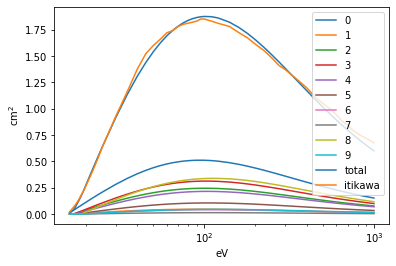

In [160]:
fig1, ax1 = plt.subplots(1)
for i in range(len(ee_pcs)):
    ax1.plot(INCIDENT_ENERGY, ee_pcs[i]*1.0E20, label='{}'.format(i))
ax1.plot(INCIDENT_ENERGY, np.sum(ee_pcs*1.0E20, axis=0), label='total')
ax1.plot(INCIDENT_ENERGY, ITIKAWA, label='itikawa')
ax1.set_xscale('log')
ax1.set_ylabel('cm$^2$')
ax1.set_xlabel('eV')
ax1.legend()
plt.show()

# Figures and Tables

## N2 X1Sigmag+ to N2+ X2Sigmag+

## N2 X1Sigmag+ to N2+ A2Piu

## N2 X1Sigmag+ to N2+ B2Sigmau+

## Comparison against Itikawa compiled cross sections
The Itikawa total cross sections need to be multiplied by 18 to reach our total